## Indexing 
We decided to index the recipes based on the directions, in order to perform keyword search over them. We choose the directions since they will likely contains both ingredients and keywords relative to the procedure (e.g. baked, fried).

In [1]:
!pip install -q python-terrier==0.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.5/119.5 kB 2.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.0/859.0 kB 17.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.0/288.0 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.7 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pyterrier as pt

if not pt.started():
  pt.init()

/tmp/ipykernel_31/2460995692.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) started. (use pt.java.started() instead) -- Deprecated since version 0.11.0.
  if not pt.started():


terrier-assemblies 5.11 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done


Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]
/tmp/ipykernel_31/2460995692.py:6: DeprecationWarning: Call to deprecated method pt.init(). Deprecated since version 0.11.0.
java is now started automatically with default settings. To force initialisation early, run:
pt.java.init() # optional, forces java initialisation
  pt.init()


In [3]:
df = pd.read_csv("/kaggle/input/recipe-sampled-0-25/sampled_dataset.csv")

In [4]:
# Create a list of documents (use 'directions' for indexing)
documents = [{'docno': str(i), 'text': text} for i, text in enumerate(df['directions'])]

# Create the index
indexer = pt.IterDictIndexer("./index")
indexer.index(documents)

19:21:54.223 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer -- Adding an empty document to the index (61876) - further warnings are suppressed
19:23:12.823 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer -- Indexed 4 empty documents


<org.terrier.querying.IndexRef at 0x79d82c2b4530 jclass=org/terrier/querying/IndexRef jself=<LocalRef obj=0x262eb2b0 at 0x79d853bb87b0>>

In [5]:
# Create documents with multiple fields
documents_fields = [
    {
        'docno': str(i),
        'title': row['title'],
        'ingredients': row['ingredients'],
        'directions': row['directions']
    }
    for i, row in df.iterrows()
]

# Index the fielded documents
indexer_fields = pt.IterDictIndexer("./index_fielded")

# Set meta fields and indexed fields
indexref = indexer_fields.index(
    documents_fields,
    fields=["title", "ingredients", "directions"],  
    meta={'docno': 20, 'title': 512, 'ingredients': 1024, 'directions': 4096}
)

In [6]:
# Create a searcher using the index
index = pt.IndexFactory.of("./index")
index_fields = pt.IndexFactory.of(indexref)

# BM25 retrieval model
bm25 = pt.terrier.Retriever(index, wmodel="BM25")

# TF-IDF retrieval model
tfidf = pt.terrier.Retriever(index, wmodel="TF_IDF")

# DFRee retrieval model (Document Frequency based)
dfree = pt.terrier.Retriever(index, wmodel="DFRee")

# BM25 model with term frequency ignored (k_1=0) and no length normalization (b=0)
bm25_no_tf = pt.terrier.Retriever(index, wmodel="BM25", controls={"k_1": "0.0", "b": "0.0"})  # k1=0 forces BM25 to ignore term frequency and only count matches

# Create BM25F retriever with field weights
# Weighted BM25 over each field
bm25_title = pt.BatchRetrieve(index_fields, wmodel="BM25", controls={"w": "1.0"}, metadata=["docno", "title"], field="title")
bm25_ingredients = pt.BatchRetrieve(index_fields, wmodel="BM25", controls={"w": "1.0"}, metadata=["docno", "ingredients"], field="ingredients")
bm25_directions = pt.BatchRetrieve(index_fields, wmodel="BM25", controls={"w": "1.0"}, metadata=["docno", "directions"], field="directions")

# Weighted combination of scores: BM25F-like
bm25f_manual = (
    bm25_title * 0.3 +
    bm25_ingredients * 0.4 +
    bm25_directions * 0.3
)

/tmp/ipykernel_31/975190942.py:19: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25_title = pt.BatchRetrieve(index_fields, wmodel="BM25", controls={"w": "1.0"}, metadata=["docno", "title"], field="title")
/tmp/ipykernel_31/975190942.py:20: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25_ingredients = pt.BatchRetrieve(index_fields, wmodel="BM25", controls={"w": "1.0"}, metadata=["docno", "ingredients"], field="ingredients")
/tmp/ipykernel_31/975190942.py:21: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25_directions = pt.BatchRetrieve(index_fields, wmodel="BM25", controls={"w": "1.0"}, metadata=["docno", "directions"], field="directions")


By using all of these models, we can perform a comprehensive evaluation of the different retrieval strategies. Each model captures different aspects of relevance:
- BM25 accounts for both term and document frequencies, providing a balanced relevance score.
- TF-IDF emphasizes the importance of rare terms across the document collection.
- DFRee is useful for understanding how document frequency affects relevance.
- The BM25 with no term frequency and no length normalization is helpful for evaluating pure term presence-based matching.

In [7]:
print(index.getCollectionStatistics().toString())

Number of documents: 557658
Number of terms: 50996
Number of postings: 22626961
Number of fields: 1
Number of tokens: 30780702
Field names: [text]
Positions:   false



In [9]:
# Prepare some queries and evaluate them
queries = [
    {"qid": "1", "query": "chicken casserole"},
    {"qid": "2", "query": "simple birthday cake"},
    {"qid": "3", "query": "baked salmon"},
]

titles = df['title']
plot_data = []

# Loop through each query
for q in queries:
    print(f"\n=== Query {q['qid']}: {q['query']} ===")

    # Run all models including BM25F
    result_bm25 = bm25.search(q['query'])
    result_tfidf = tfidf.search(q['query'])
    result_dfree = dfree.search(q['query'])
    result_bm25_no_tf = bm25_no_tf.search(q['query'])
    result_bm25f = bm25f_manual.search(q['query'])  

    # Add all model results to the loop
    for method_name, result in [
        ("BM25", result_bm25),
        ("TF-IDF", result_tfidf),
        ("DFRee", result_dfree),
        ("BM25_no_tf", result_bm25_no_tf),
        ("BM25F", result_bm25f) 
    ]:
        print(f"\n--- Method: {method_name} ---")

        for rank, docno in enumerate(result["docno"][:5]):
            docno_int = int(docno)  # Convert from str to int
            title = titles.iloc[docno_int] if docno_int < len(titles) else "TITLE NOT FOUND"
            print(f"Docno: {docno} | Title: {title}")
            
            # Append to plotting data
            plot_data.append({
                'Query': q['query'],
                'Query_ID': q['qid'],
                'Model': method_name,
                'Rank': rank + 1,
                'Docno': docno_int,
                'Title': title
            })



=== Query 1: chicken casserole ===


TerrierRetr(BM25):   0%|          | 0/1 [00:00<?, ?q/s]

19:27:02.216 [main] WARN org.terrier.structures.FSADocumentIndex -- This index has fields, but FSADocumentIndex is used (which stores fields lengths on disk); If using field-based models such as BM25F, change to index.document.class in the index  properties file to FSAFieldDocumentIndex or FSADocumentIndexInMemFields to support efficient retrieval. If you don't use (e.g.) BM25F, this warning can be ignored


TerrierRetr(BM25): 100%|██████████| 1/1 [00:00<00:00,  8.82q/s]



--- Method: BM25 ---
Docno: 60998 | Title: Bob'S Deluxe Chicken
Docno: 504597 | Title: Lennie'S Chicken And Rice
Docno: 329261 | Title: Quick Chicken Pot Pie
Docno: 130370 | Title: Chicken Enchiladas
Docno: 444448 | Title: Kings Ranch Chicken Casserole

--- Method: TF-IDF ---
Docno: 60998 | Title: Bob'S Deluxe Chicken
Docno: 504597 | Title: Lennie'S Chicken And Rice
Docno: 329261 | Title: Quick Chicken Pot Pie
Docno: 444448 | Title: Kings Ranch Chicken Casserole
Docno: 130370 | Title: Chicken Enchiladas

--- Method: DFRee ---
Docno: 444448 | Title: Kings Ranch Chicken Casserole
Docno: 504597 | Title: Lennie'S Chicken And Rice
Docno: 123733 | Title: Chicken Casserole
Docno: 329261 | Title: Quick Chicken Pot Pie
Docno: 103313 | Title: Lemon Confit Chicken with Calamata Olives

--- Method: BM25_no_tf ---
Docno: 60998 | Title: Bob'S Deluxe Chicken
Docno: 504597 | Title: Lennie'S Chicken And Rice
Docno: 329261 | Title: Quick Chicken Pot Pie
Docno: 130370 | Title: Chicken Enchiladas
Docno: 

TerrierRetr(BM25): 100%|██████████| 1/1 [00:00<00:00, 11.27q/s]



--- Method: BM25 ---
Docno: 470068 | Title: Tiny Fruitcakes
Docno: 318994 | Title: Decorative Icing
Docno: 358491 | Title: Popcorn Balls(That Stay Soft)  
Docno: 65593 | Title: Cranberry Sparkler
Docno: 483258 | Title: Aperol Spritz

--- Method: TF-IDF ---
Docno: 470068 | Title: Tiny Fruitcakes
Docno: 318994 | Title: Decorative Icing
Docno: 358491 | Title: Popcorn Balls(That Stay Soft)  
Docno: 65593 | Title: Cranberry Sparkler
Docno: 483258 | Title: Aperol Spritz

--- Method: DFRee ---
Docno: 289067 | Title: Character Made With Chocolate (Doraemon)
Docno: 55535 | Title: No Eggs, Food-Allergy Friendly Spongecake
Docno: 100734 | Title: Swedish Birthday Cake
Docno: 92047 | Title: Space Mansion Birthday Cake
Docno: 492363 | Title: Birthday Cake

--- Method: BM25_no_tf ---
Docno: 470068 | Title: Tiny Fruitcakes
Docno: 318994 | Title: Decorative Icing
Docno: 358491 | Title: Popcorn Balls(That Stay Soft)  
Docno: 65593 | Title: Cranberry Sparkler
Docno: 483258 | Title: Aperol Spritz

--- Me

TerrierRetr(BM25): 100%|██████████| 1/1 [00:00<00:00,  7.77q/s]


--- Method: BM25 ---
Docno: 233225 | Title: Yummy Salmon
Docno: 300496 | Title: Balsamic Glazed Salmon 
Docno: 69969 | Title: Lavender Honey Salmon
Docno: 102573 | Title: Oven-baked salmon
Docno: 418148 | Title: Fennel- And Dill-Rubbed Grilled Salmon 

--- Method: TF-IDF ---
Docno: 300496 | Title: Balsamic Glazed Salmon 
Docno: 418148 | Title: Fennel- And Dill-Rubbed Grilled Salmon 
Docno: 69969 | Title: Lavender Honey Salmon
Docno: 385339 | Title: Lemon-Pepper Salmon Ii
Docno: 287067 | Title: Baked Salmon with Black Olive Salsa

--- Method: DFRee ---
Docno: 418148 | Title: Fennel- And Dill-Rubbed Grilled Salmon 
Docno: 13194 | Title: Salmon Wrapped In Fig Leaves With Baked Kale
Docno: 300496 | Title: Balsamic Glazed Salmon 
Docno: 341592 | Title: Crusted Salmon With Honey-Mustard Sauce
Docno: 529699 | Title: Roasted Salmon

--- Method: BM25_no_tf ---
Docno: 233225 | Title: Yummy Salmon
Docno: 300496 | Title: Balsamic Glazed Salmon 
Docno: 69969 | Title: Lavender Honey Salmon
Docno: 1

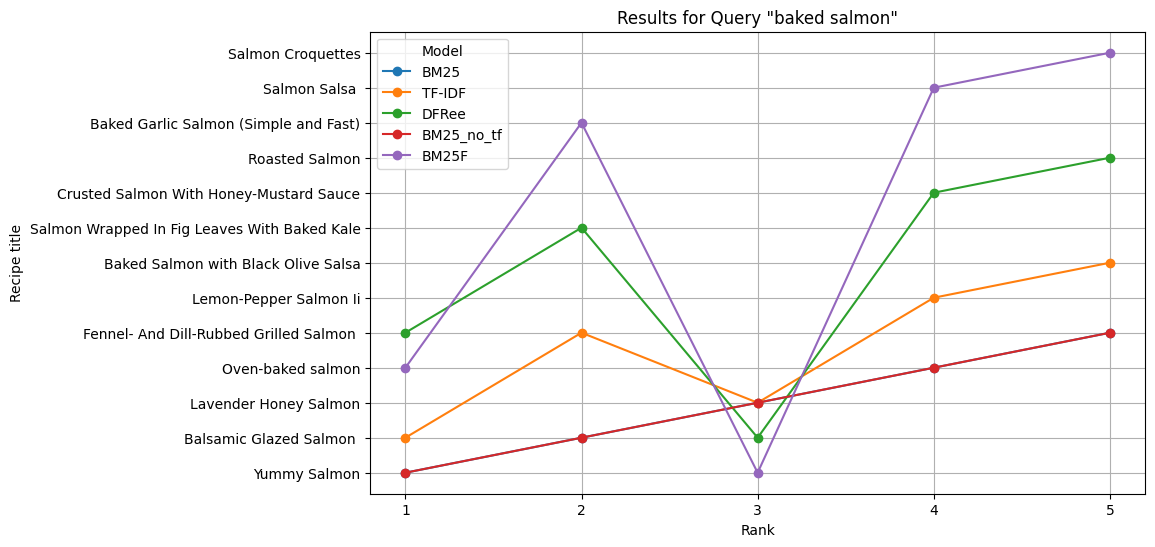

In [10]:
# Visualize the results of the third query
plot_df = pd.DataFrame(plot_data)
df_first = plot_df[plot_df['Query_ID'] == "3"]

plt.figure(figsize=(10, 6))

for model in df_first['Model'].unique():
    md = df_first[df_first['Model'] == model]
    plt.plot(md['Rank'], md['Title'], marker='o', linestyle='-', label=model)

plt.xlabel('Rank')
plt.ylabel('Recipe title')
plt.title(f'Results for Query "{queries[2]["query"]}"')
plt.legend(title='Model')
plt.xticks([1, 2, 3, 4, 5])
plt.grid(True)
plt.show()

About the results:
- BM25 and BM25_no_tf produces the same results since every top-5 recipe contains “baked” and “salmon” exactly once, and length normalization doesn’t change their relative scores.
- TF-IDF also agrees on “Balsamic Glazed Salmon” at #2, but for #1 it picks “Yummy Salmon” instead of “Fennel-And-Dill-Rubbed Grilled Salmon” (DFRee’s choice). We can see that TF-IDF’s emphasis on rare terms may be boosting “balsamic”.
- DFRee puts “Fennel-And-Dill-Rubbed Grilled Salmon” at #1, and then “Salmon Wrapped In Fig Leaves With Baked Kale” at #2: it shows that rarer, longer titles win more weight under DFRee.
- Unlike single-field models, BM25F combines weighted evidence from different parts of the document, making it robust when key terms appear in ingredients or title, not just the directions. 